In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import utils
keras = tf.keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)

In [ ]:
fname = '10-transfer-learning-cnn.pickle'
vartbl = utils.load_vartbl(fname)

In [3]:
tfds.disable_progress_bar()

In [4]:
SPLIT_WEIGHTS = (8, 1, 1,)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_trn, raw_val, raw_tst), metadata = tfds.load('cats_vs_dogs', split=list(splits), with_info=True, as_supervised=True)

In [5]:
print(raw_trn)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
get_label_name = metadata.features['label'].int2str

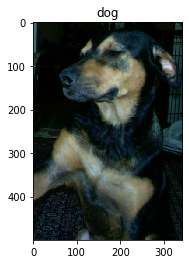

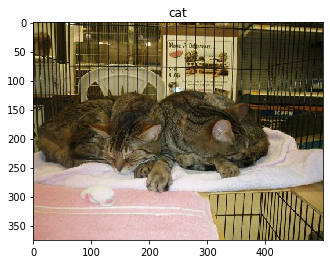

In [7]:
for img, label in raw_trn.take(2):
    plt.figure()
    plt.imshow(img)
    plt.title(get_label_name(label))

In [8]:
IMG_SIZE = 160

def format_example(img, label):
    img = tf.cast(img, tf.float32)
    img = img / 127.5 - 1.0
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, label

In [9]:
data_trn = raw_trn.map(format_example)
data_val = raw_val.map(format_example)
data_tst = raw_tst.map(format_example)

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024

In [11]:
batches_trn = data_trn.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
batches_val = data_val.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
batches_tst = data_tst.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
for image_batch, label_batch in batches_trn.take(1):
    pass
image_batch.shape

TensorShape([32, 160, 160, 3])

In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

model_base = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [21]:
model_base.trainable = False

In [22]:
model_base.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 20, 20, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 20, 20, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 20, 20, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 20, 20, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 20, 20, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 10, 10, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 10, 10, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 10, 10, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 10, 10, 384)  24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 10, 10, 576)  2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 10, 10, 576)  0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 11, 11, 576)  0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 5, 5, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 5, 5, 576)    2304        block_13_depthwise[0][0]         
__________

In [23]:
feature_batch = model_base(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 1280])

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [25]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 1])

In [27]:
model = keras.Sequential([
    model_base,
    global_average_layer,
    prediction_layer
])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.RMSprop(lr=base_learning_rate),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [37]:
num_all = metadata.splits['train'].num_examples
num_trn, num_val, num_tst = (num_all*weight/10 for weight in SPLIT_WEIGHTS)
print('Number of Samples')
print(f'Train: {num_trn}')
print(f'Val  : {num_val}')
print(f'Test : {num_tst}')

Number of Samples
Train: 18609.6
Val  : 2326.2
Test : 2326.2


In [39]:
initial_epochs = 10
steps_per_epoch = round(num_trn) // BATCH_SIZE
validation_steps = 20
loss0, accuracy0 = model.evaluate(batches_val, steps=validation_steps)

20/20 [==============================] - ETA: 1:21 - loss: 4.4183 - accuracy: 0.65 - ETA: 39s - loss: 5.6178 - accuracy: 0.5938 - ETA: 25s - loss: 5.7435 - accuracy: 0.552 - ETA: 18s - loss: 5.7139 - accuracy: 0.546 - ETA: 13s - loss: 6.0585 - accuracy: 0.525 - ETA: 10s - loss: 6.2548 - accuracy: 0.526 - ETA: 8s - loss: 6.3617 - accuracy: 0.517 - ETA: 7s - loss: 6.4921 - accuracy: 0.50 - ETA: 6s - loss: 6.5281 - accuracy: 0.51 - ETA: 5s - loss: 6.7698 - accuracy: 0.49 - ETA: 4s - loss: 6.7331 - accuracy: 0.49 - ETA: 3s - loss: 6.6712 - accuracy: 0.49 - ETA: 2s - loss: 6.7254 - accuracy: 0.49 - ETA: 2s - loss: 6.8409 - accuracy: 0.48 - ETA: 1s - loss: 6.6251 - accuracy: 0.49 - ETA: 1s - loss: 6.5163 - accuracy: 0.50 - ETA: 0s - loss: 6.3961 - accuracy: 0.51 - ETA: 0s - loss: 6.3451 - accuracy: 0.52 - ETA: 0s - loss: 6.4425 - accuracy: 0.51 - 6s 295ms/step - loss: 6.3273 - accuracy: 0.5219


In [43]:
print(f'Initial loss: {loss0:.2f}')
print(f'Initial accuracy: {accuracy0:.4f}')

Initial loss: 6.33
Initial accuracy: 0.5219


In [44]:
history = model.fit(batches_trn, epochs=initial_epochs, validation_data = batches_val)

Epoch 1/10


W0610 10:45:58.542773 35504 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


    168/Unknown - 5s 5s/step - loss: 5.7558 - accuracy: 0.43 - 5s 2s/step - loss: 5.8660 - accuracy: 0.46 - 5s 2s/step - loss: 6.0693 - accuracy: 0.47 - 5s 1s/step - loss: 6.1542 - accuracy: 0.49 - 5s 1s/step - loss: 6.3530 - accuracy: 0.47 - 5s 879ms/step - loss: 6.2430 - accuracy: 0.468 - 5s 767ms/step - loss: 6.1530 - accuracy: 0.473 - 5s 684ms/step - loss: 6.0867 - accuracy: 0.476 - 6s 617ms/step - loss: 5.9206 - accuracy: 0.493 - 6s 565ms/step - loss: 5.9733 - accuracy: 0.484 - 6s 523ms/step - loss: 6.1165 - accuracy: 0.474 - 6s 488ms/step - loss: 6.0819 - accuracy: 0.479 - 6s 458ms/step - loss: 6.1799 - accuracy: 0.478 - 6s 431ms/step - loss: 6.2550 - accuracy: 0.466 - 6s 409ms/step - loss: 6.2872 - accuracy: 0.456 - 6s 389ms/step - loss: 6.1554 - accuracy: 0.468 - 6s 372ms/step - loss: 6.0750 - accuracy: 0.468 - 6s 357ms/step - loss: 6.1209 - accuracy: 0.461 - 7s 343ms/step - loss: 5.9757 - accuracy: 0.465 - 7s 330ms/step - loss: 5.8846 - accuracy: 0.470 - 7s 319ms/step - loss: 

    335/Unknown - 21s 124ms/step - loss: 4.8838 - accuracy: 0.49 - 21s 124ms/step - loss: 4.8832 - accuracy: 0.49 - 21s 124ms/step - loss: 4.8660 - accuracy: 0.49 - 21s 124ms/step - loss: 4.8536 - accuracy: 0.49 - 21s 123ms/step - loss: 4.8482 - accuracy: 0.49 - 21s 123ms/step - loss: 4.8370 - accuracy: 0.49 - 22s 123ms/step - loss: 4.8189 - accuracy: 0.50 - 22s 123ms/step - loss: 4.8137 - accuracy: 0.50 - 22s 123ms/step - loss: 4.8016 - accuracy: 0.50 - 22s 123ms/step - loss: 4.8010 - accuracy: 0.50 - 22s 123ms/step - loss: 4.7998 - accuracy: 0.50 - 22s 122ms/step - loss: 4.7854 - accuracy: 0.50 - 22s 122ms/step - loss: 4.7727 - accuracy: 0.50 - 22s 122ms/step - loss: 4.7663 - accuracy: 0.50 - 22s 122ms/step - loss: 4.7605 - accuracy: 0.50 - 22s 122ms/step - loss: 4.7477 - accuracy: 0.50 - 23s 122ms/step - loss: 4.7419 - accuracy: 0.50 - 23s 122ms/step - loss: 4.7485 - accuracy: 0.50 - 23s 122ms/step - loss: 4.7407 - accuracy: 0.50 - 23s 122ms/step - loss: 4.7358 - accuracy: 0.50 - 23

    502/Unknown - 37s 110ms/step - loss: 3.8597 - accuracy: 0.56 - 37s 110ms/step - loss: 3.8534 - accuracy: 0.56 - 37s 110ms/step - loss: 3.8539 - accuracy: 0.56 - 37s 110ms/step - loss: 3.8491 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8430 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8398 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8334 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8352 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8336 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8302 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8311 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8272 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8226 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8171 - accuracy: 0.56 - 38s 110ms/step - loss: 3.8073 - accuracy: 0.56 - 39s 110ms/step - loss: 3.7999 - accuracy: 0.56 - 39s 110ms/step - loss: 3.7992 - accuracy: 0.56 - 39s 110ms/step - loss: 3.7964 - accuracy: 0.56 - 39s 110ms/step - loss: 3.7915 - accuracy: 0.56 - 39s 110ms/step - loss: 3.7859 - accuracy: 0.56 - 39

582/582 [==============================] 3.2301 - accuracy: 0.62 - 53s 106ms/step - loss: 3.2289 - accuracy: 0.62 - 53s 106ms/step - loss: 3.2232 - accuracy: 0.62 - 54s 106ms/step - loss: 3.2192 - accuracy: 0.62 - 54s 106ms/step - loss: 3.2143 - accuracy: 0.62 - 54s 106ms/step - loss: 3.2111 - accuracy: 0.62 - 54s 106ms/step - loss: 3.2079 - accuracy: 0.62 - 54s 106ms/step - loss: 3.2045 - accuracy: 0.62 - 54s 106ms/step - loss: 3.2013 - accuracy: 0.62 - 54s 106ms/step - loss: 3.2009 - accuracy: 0.62 - 54s 106ms/step - loss: 3.1988 - accuracy: 0.62 - 54s 106ms/step - loss: 3.1974 - accuracy: 0.62 - 55s 106ms/step - loss: 3.1945 - accuracy: 0.62 - 55s 106ms/step - loss: 3.1907 - accuracy: 0.62 - 55s 106ms/step - loss: 3.1866 - accuracy: 0.62 - 55s 106ms/step - loss: 3.1819 - accuracy: 0.62 - 55s 106ms/step - loss: 3.1792 - accuracy: 0.62 - 55s 106ms/step - loss: 3.1757 - accuracy: 0.62 - 55s 106ms/step - loss: 3.1720 - accuracy: 0.62 - 55s 106ms/step - loss: 3.1691 - accuracy: 0.62 - 55

186/582 [========>.....................] - ETA: 20:00 - loss: 0.6070 - accuracy: 0.875 - ETA: 10:27 - loss: 0.8498 - accuracy: 0.875 - ETA: 7:16 - loss: 0.9858 - accuracy: 0.833 - ETA: 5:40 - loss: 0.9929 - accuracy: 0.85 - ETA: 4:43 - loss: 0.8664 - accuracy: 0.85 - ETA: 4:04 - loss: 0.7569 - accuracy: 0.85 - ETA: 3:37 - loss: 0.8329 - accuracy: 0.84 - ETA: 3:17 - loss: 0.7586 - accuracy: 0.85 - ETA: 3:01 - loss: 1.0151 - accuracy: 0.83 - ETA: 2:48 - loss: 1.1170 - accuracy: 0.83 - ETA: 2:37 - loss: 1.2153 - accuracy: 0.82 - ETA: 2:28 - loss: 1.1694 - accuracy: 0.82 - ETA: 2:21 - loss: 1.2385 - accuracy: 0.82 - ETA: 2:15 - loss: 1.3103 - accuracy: 0.81 - ETA: 2:09 - loss: 1.4138 - accuracy: 0.79 - ETA: 2:04 - loss: 1.4049 - accuracy: 0.79 - ETA: 2:00 - loss: 1.3990 - accuracy: 0.79 - ETA: 1:56 - loss: 1.4107 - accuracy: 0.78 - ETA: 1:53 - loss: 1.4271 - accuracy: 0.78 - ETA: 1:50 - loss: 1.3626 - accuracy: 0.79 - ETA: 1:47 - loss: 1.3125 - accuracy: 0.79 - ETA: 1:44 - loss: 1.3684 - a

372/582 [==================>...........] - ETA: 42s - loss: 1.3336 - accuracy: 0.814 - ETA: 42s - loss: 1.3327 - accuracy: 0.814 - ETA: 42s - loss: 1.3339 - accuracy: 0.814 - ETA: 42s - loss: 1.3339 - accuracy: 0.814 - ETA: 42s - loss: 1.3279 - accuracy: 0.814 - ETA: 41s - loss: 1.3246 - accuracy: 0.814 - ETA: 41s - loss: 1.3287 - accuracy: 0.814 - ETA: 41s - loss: 1.3282 - accuracy: 0.813 - ETA: 41s - loss: 1.3293 - accuracy: 0.814 - ETA: 41s - loss: 1.3308 - accuracy: 0.814 - ETA: 41s - loss: 1.3297 - accuracy: 0.814 - ETA: 41s - loss: 1.3283 - accuracy: 0.815 - ETA: 41s - loss: 1.3274 - accuracy: 0.815 - ETA: 40s - loss: 1.3305 - accuracy: 0.815 - ETA: 40s - loss: 1.3325 - accuracy: 0.815 - ETA: 40s - loss: 1.3294 - accuracy: 0.815 - ETA: 40s - loss: 1.3264 - accuracy: 0.815 - ETA: 40s - loss: 1.3229 - accuracy: 0.816 - ETA: 40s - loss: 1.3216 - accuracy: 0.816 - ETA: 40s - loss: 1.3223 - accuracy: 0.816 - ETA: 40s - loss: 1.3221 - accuracy: 0.816 - ETA: 39s - loss: 1.3211 - accurac

569/582 [============================>.] - ETA: 21s - loss: 1.2609 - accuracy: 0.826 - ETA: 21s - loss: 1.2593 - accuracy: 0.826 - ETA: 21s - loss: 1.2608 - accuracy: 0.826 - ETA: 21s - loss: 1.2590 - accuracy: 0.826 - ETA: 20s - loss: 1.2574 - accuracy: 0.826 - ETA: 20s - loss: 1.2556 - accuracy: 0.826 - ETA: 20s - loss: 1.2540 - accuracy: 0.826 - ETA: 20s - loss: 1.2523 - accuracy: 0.827 - ETA: 20s - loss: 1.2546 - accuracy: 0.826 - ETA: 20s - loss: 1.2518 - accuracy: 0.827 - ETA: 20s - loss: 1.2514 - accuracy: 0.827 - ETA: 20s - loss: 1.2491 - accuracy: 0.827 - ETA: 20s - loss: 1.2513 - accuracy: 0.827 - ETA: 20s - loss: 1.2484 - accuracy: 0.827 - ETA: 19s - loss: 1.2469 - accuracy: 0.827 - ETA: 19s - loss: 1.2463 - accuracy: 0.827 - ETA: 19s - loss: 1.2473 - accuracy: 0.827 - ETA: 19s - loss: 1.2482 - accuracy: 0.827 - ETA: 19s - loss: 1.2476 - accuracy: 0.828 - ETA: 19s - loss: 1.2460 - accuracy: 0.828 - ETA: 19s - loss: 1.2432 - accuracy: 0.828 - ETA: 19s - loss: 1.2437 - accurac

582/582 [==============================] - ETA: 1s - loss: 1.1580 - accuracy: 0.83 - ETA: 0s - loss: 1.1553 - accuracy: 0.83 - ETA: 0s - loss: 1.1547 - accuracy: 0.83 - ETA: 0s - loss: 1.1559 - accuracy: 0.83 - ETA: 0s - loss: 1.1540 - accuracy: 0.83 - ETA: 0s - loss: 1.1551 - accuracy: 0.83 - 63s 109ms/step - loss: 1.1540 - accuracy: 0.8397 - val_loss: 0.6752 - val_accuracy: 0.9078
Epoch 3/10


186/582 [========>.....................] - ETA: 19:46 - loss: 0.5535 - accuracy: 0.937 - ETA: 10:21 - loss: 0.5897 - accuracy: 0.921 - ETA: 7:12 - loss: 0.4533 - accuracy: 0.916 - ETA: 5:38 - loss: 0.4787 - accuracy: 0.92 - ETA: 4:41 - loss: 0.3964 - accuracy: 0.93 - ETA: 4:04 - loss: 0.3551 - accuracy: 0.93 - ETA: 3:37 - loss: 0.3951 - accuracy: 0.92 - ETA: 3:16 - loss: 0.3606 - accuracy: 0.92 - ETA: 2:59 - loss: 0.5501 - accuracy: 0.91 - ETA: 2:47 - loss: 0.6892 - accuracy: 0.90 - ETA: 2:37 - loss: 0.7316 - accuracy: 0.90 - ETA: 2:28 - loss: 0.7171 - accuracy: 0.90 - ETA: 2:20 - loss: 0.7506 - accuracy: 0.89 - ETA: 2:15 - loss: 0.8431 - accuracy: 0.89 - ETA: 2:09 - loss: 0.8979 - accuracy: 0.88 - ETA: 2:04 - loss: 0.9095 - accuracy: 0.88 - ETA: 1:59 - loss: 0.9164 - accuracy: 0.88 - ETA: 1:56 - loss: 0.9314 - accuracy: 0.88 - ETA: 1:52 - loss: 0.9661 - accuracy: 0.87 - ETA: 1:49 - loss: 0.9209 - accuracy: 0.87 - ETA: 1:46 - loss: 0.8860 - accuracy: 0.88 - ETA: 1:44 - loss: 0.8985 - a

372/582 [==================>...........] - ETA: 41s - loss: 0.8973 - accuracy: 0.878 - ETA: 41s - loss: 0.8981 - accuracy: 0.878 - ETA: 41s - loss: 0.9013 - accuracy: 0.878 - ETA: 41s - loss: 0.9002 - accuracy: 0.878 - ETA: 41s - loss: 0.8961 - accuracy: 0.879 - ETA: 41s - loss: 0.8945 - accuracy: 0.879 - ETA: 41s - loss: 0.9001 - accuracy: 0.879 - ETA: 41s - loss: 0.9007 - accuracy: 0.879 - ETA: 40s - loss: 0.9039 - accuracy: 0.879 - ETA: 40s - loss: 0.9048 - accuracy: 0.879 - ETA: 40s - loss: 0.9078 - accuracy: 0.879 - ETA: 40s - loss: 0.9042 - accuracy: 0.879 - ETA: 40s - loss: 0.9054 - accuracy: 0.879 - ETA: 40s - loss: 0.9018 - accuracy: 0.879 - ETA: 40s - loss: 0.9038 - accuracy: 0.879 - ETA: 40s - loss: 0.9022 - accuracy: 0.879 - ETA: 39s - loss: 0.8986 - accuracy: 0.879 - ETA: 39s - loss: 0.8968 - accuracy: 0.880 - ETA: 39s - loss: 0.8953 - accuracy: 0.880 - ETA: 39s - loss: 0.8939 - accuracy: 0.880 - ETA: 39s - loss: 0.8950 - accuracy: 0.880 - ETA: 39s - loss: 0.8958 - accurac

569/582 [============================>.] - ETA: 21s - loss: 0.8731 - accuracy: 0.883 - ETA: 21s - loss: 0.8722 - accuracy: 0.883 - ETA: 20s - loss: 0.8734 - accuracy: 0.883 - ETA: 20s - loss: 0.8725 - accuracy: 0.883 - ETA: 20s - loss: 0.8718 - accuracy: 0.883 - ETA: 20s - loss: 0.8708 - accuracy: 0.883 - ETA: 20s - loss: 0.8700 - accuracy: 0.883 - ETA: 20s - loss: 0.8691 - accuracy: 0.884 - ETA: 20s - loss: 0.8709 - accuracy: 0.884 - ETA: 20s - loss: 0.8689 - accuracy: 0.884 - ETA: 20s - loss: 0.8670 - accuracy: 0.884 - ETA: 19s - loss: 0.8662 - accuracy: 0.884 - ETA: 19s - loss: 0.8659 - accuracy: 0.884 - ETA: 19s - loss: 0.8638 - accuracy: 0.884 - ETA: 19s - loss: 0.8619 - accuracy: 0.884 - ETA: 19s - loss: 0.8623 - accuracy: 0.884 - ETA: 19s - loss: 0.8641 - accuracy: 0.884 - ETA: 19s - loss: 0.8660 - accuracy: 0.884 - ETA: 19s - loss: 0.8663 - accuracy: 0.884 - ETA: 19s - loss: 0.8655 - accuracy: 0.884 - ETA: 19s - loss: 0.8635 - accuracy: 0.885 - ETA: 18s - loss: 0.8656 - accurac

582/582 [==============================] - ETA: 1s - loss: 0.8232 - accuracy: 0.88 - ETA: 0s - loss: 0.8224 - accuracy: 0.88 - ETA: 0s - loss: 0.8228 - accuracy: 0.88 - ETA: 0s - loss: 0.8212 - accuracy: 0.88 - ETA: 0s - loss: 0.8218 - accuracy: 0.88 - ETA: 0s - loss: 0.8201 - accuracy: 0.88 - ETA: 0s - loss: 0.8223 - accuracy: 0.88 - 62s 107ms/step - loss: 0.8230 - accuracy: 0.8890 - val_loss: 0.7190 - val_accuracy: 0.9181
Epoch 4/10


186/582 [========>.....................] - ETA: 20:29 - loss: 0.1533 - accuracy: 0.937 - ETA: 10:42 - loss: 0.0943 - accuracy: 0.953 - ETA: 7:27 - loss: 0.0849 - accuracy: 0.958 - ETA: 5:49 - loss: 0.1940 - accuracy: 0.96 - ETA: 4:50 - loss: 0.1592 - accuracy: 0.96 - ETA: 4:11 - loss: 0.1562 - accuracy: 0.95 - ETA: 3:43 - loss: 0.1515 - accuracy: 0.95 - ETA: 3:21 - loss: 0.1444 - accuracy: 0.95 - ETA: 3:05 - loss: 0.3498 - accuracy: 0.94 - ETA: 2:52 - loss: 0.5089 - accuracy: 0.93 - ETA: 2:41 - loss: 0.5194 - accuracy: 0.93 - ETA: 2:32 - loss: 0.5208 - accuracy: 0.93 - ETA: 2:24 - loss: 0.5378 - accuracy: 0.93 - ETA: 2:18 - loss: 0.6166 - accuracy: 0.92 - ETA: 2:12 - loss: 0.6795 - accuracy: 0.91 - ETA: 2:08 - loss: 0.6993 - accuracy: 0.91 - ETA: 2:03 - loss: 0.6886 - accuracy: 0.92 - ETA: 2:00 - loss: 0.7607 - accuracy: 0.91 - ETA: 1:56 - loss: 0.7642 - accuracy: 0.91 - ETA: 1:53 - loss: 0.7274 - accuracy: 0.91 - ETA: 1:50 - loss: 0.7203 - accuracy: 0.91 - ETA: 1:47 - loss: 0.7162 - a

372/582 [==================>...........] - ETA: 42s - loss: 0.7074 - accuracy: 0.903 - ETA: 42s - loss: 0.7069 - accuracy: 0.903 - ETA: 42s - loss: 0.7110 - accuracy: 0.903 - ETA: 42s - loss: 0.7103 - accuracy: 0.903 - ETA: 42s - loss: 0.7070 - accuracy: 0.903 - ETA: 41s - loss: 0.7062 - accuracy: 0.903 - ETA: 41s - loss: 0.7106 - accuracy: 0.903 - ETA: 41s - loss: 0.7120 - accuracy: 0.903 - ETA: 41s - loss: 0.7160 - accuracy: 0.903 - ETA: 41s - loss: 0.7177 - accuracy: 0.903 - ETA: 41s - loss: 0.7200 - accuracy: 0.903 - ETA: 41s - loss: 0.7171 - accuracy: 0.903 - ETA: 41s - loss: 0.7148 - accuracy: 0.903 - ETA: 40s - loss: 0.7120 - accuracy: 0.902 - ETA: 40s - loss: 0.7115 - accuracy: 0.902 - ETA: 40s - loss: 0.7110 - accuracy: 0.902 - ETA: 40s - loss: 0.7083 - accuracy: 0.902 - ETA: 40s - loss: 0.7073 - accuracy: 0.903 - ETA: 40s - loss: 0.7050 - accuracy: 0.903 - ETA: 40s - loss: 0.7043 - accuracy: 0.903 - ETA: 40s - loss: 0.7061 - accuracy: 0.902 - ETA: 39s - loss: 0.7056 - accurac

571/582 [============================>.] - ETA: 21s - loss: 0.7075 - accuracy: 0.903 - ETA: 21s - loss: 0.7058 - accuracy: 0.903 - ETA: 21s - loss: 0.7073 - accuracy: 0.903 - ETA: 21s - loss: 0.7057 - accuracy: 0.903 - ETA: 21s - loss: 0.7053 - accuracy: 0.903 - ETA: 21s - loss: 0.7048 - accuracy: 0.903 - ETA: 21s - loss: 0.7044 - accuracy: 0.903 - ETA: 20s - loss: 0.7039 - accuracy: 0.903 - ETA: 20s - loss: 0.7060 - accuracy: 0.903 - ETA: 20s - loss: 0.7044 - accuracy: 0.904 - ETA: 20s - loss: 0.7028 - accuracy: 0.904 - ETA: 20s - loss: 0.7023 - accuracy: 0.904 - ETA: 20s - loss: 0.7025 - accuracy: 0.904 - ETA: 20s - loss: 0.7007 - accuracy: 0.904 - ETA: 20s - loss: 0.6992 - accuracy: 0.904 - ETA: 20s - loss: 0.6989 - accuracy: 0.904 - ETA: 20s - loss: 0.7011 - accuracy: 0.904 - ETA: 19s - loss: 0.7033 - accuracy: 0.904 - ETA: 19s - loss: 0.7040 - accuracy: 0.904 - ETA: 19s - loss: 0.7025 - accuracy: 0.904 - ETA: 19s - loss: 0.7009 - accuracy: 0.904 - ETA: 19s - loss: 0.7032 - accurac

582/582 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.90 - ETA: 0s - loss: 0.6759 - accuracy: 0.90 - ETA: 0s - loss: 0.6771 - accuracy: 0.90 - ETA: 0s - loss: 0.6753 - accuracy: 0.90 - ETA: 0s - loss: 0.6769 - accuracy: 0.90 - 65s 111ms/step - loss: 0.6781 - accuracy: 0.9081 - val_loss: 0.5368 - val_accuracy: 0.9384
Epoch 5/10


186/582 [========>.....................] - ETA: 20:10 - loss: 0.5247 - accuracy: 0.937 - ETA: 10:32 - loss: 0.2802 - accuracy: 0.953 - ETA: 7:20 - loss: 0.2120 - accuracy: 0.947 - ETA: 5:44 - loss: 0.2849 - accuracy: 0.95 - ETA: 4:47 - loss: 0.2306 - accuracy: 0.96 - ETA: 4:09 - loss: 0.2095 - accuracy: 0.95 - ETA: 3:41 - loss: 0.1906 - accuracy: 0.95 - ETA: 3:20 - loss: 0.1730 - accuracy: 0.96 - ETA: 3:03 - loss: 0.3743 - accuracy: 0.94 - ETA: 2:50 - loss: 0.5294 - accuracy: 0.94 - ETA: 2:39 - loss: 0.5328 - accuracy: 0.94 - ETA: 2:30 - loss: 0.5320 - accuracy: 0.94 - ETA: 2:24 - loss: 0.5388 - accuracy: 0.93 - ETA: 2:17 - loss: 0.6142 - accuracy: 0.93 - ETA: 2:12 - loss: 0.6437 - accuracy: 0.92 - ETA: 2:07 - loss: 0.6663 - accuracy: 0.92 - ETA: 2:03 - loss: 0.6316 - accuracy: 0.93 - ETA: 1:59 - loss: 0.7048 - accuracy: 0.92 - ETA: 1:55 - loss: 0.7018 - accuracy: 0.92 - ETA: 1:52 - loss: 0.6688 - accuracy: 0.92 - ETA: 1:49 - loss: 0.6631 - accuracy: 0.92 - ETA: 1:47 - loss: 0.6593 - a

372/582 [==================>...........] - ETA: 44s - loss: 0.6142 - accuracy: 0.917 - ETA: 44s - loss: 0.6139 - accuracy: 0.917 - ETA: 44s - loss: 0.6160 - accuracy: 0.917 - ETA: 44s - loss: 0.6159 - accuracy: 0.917 - ETA: 44s - loss: 0.6131 - accuracy: 0.917 - ETA: 44s - loss: 0.6127 - accuracy: 0.918 - ETA: 43s - loss: 0.6174 - accuracy: 0.917 - ETA: 43s - loss: 0.6193 - accuracy: 0.917 - ETA: 43s - loss: 0.6238 - accuracy: 0.917 - ETA: 43s - loss: 0.6238 - accuracy: 0.917 - ETA: 43s - loss: 0.6258 - accuracy: 0.917 - ETA: 43s - loss: 0.6231 - accuracy: 0.917 - ETA: 43s - loss: 0.6231 - accuracy: 0.917 - ETA: 43s - loss: 0.6203 - accuracy: 0.917 - ETA: 42s - loss: 0.6185 - accuracy: 0.917 - ETA: 42s - loss: 0.6159 - accuracy: 0.917 - ETA: 42s - loss: 0.6135 - accuracy: 0.917 - ETA: 42s - loss: 0.6129 - accuracy: 0.917 - ETA: 42s - loss: 0.6127 - accuracy: 0.917 - ETA: 42s - loss: 0.6103 - accuracy: 0.917 - ETA: 42s - loss: 0.6103 - accuracy: 0.917 - ETA: 41s - loss: 0.6102 - accurac

568/582 [============================>.] - ETA: 22s - loss: 0.6115 - accuracy: 0.917 - ETA: 22s - loss: 0.6100 - accuracy: 0.917 - ETA: 22s - loss: 0.6115 - accuracy: 0.917 - ETA: 22s - loss: 0.6100 - accuracy: 0.917 - ETA: 22s - loss: 0.6098 - accuracy: 0.917 - ETA: 21s - loss: 0.6096 - accuracy: 0.917 - ETA: 21s - loss: 0.6094 - accuracy: 0.917 - ETA: 21s - loss: 0.6092 - accuracy: 0.917 - ETA: 21s - loss: 0.6115 - accuracy: 0.917 - ETA: 21s - loss: 0.6100 - accuracy: 0.917 - ETA: 21s - loss: 0.6086 - accuracy: 0.917 - ETA: 21s - loss: 0.6083 - accuracy: 0.917 - ETA: 21s - loss: 0.6095 - accuracy: 0.917 - ETA: 21s - loss: 0.6080 - accuracy: 0.918 - ETA: 20s - loss: 0.6066 - accuracy: 0.918 - ETA: 20s - loss: 0.6055 - accuracy: 0.918 - ETA: 20s - loss: 0.6091 - accuracy: 0.917 - ETA: 20s - loss: 0.6104 - accuracy: 0.917 - ETA: 20s - loss: 0.6113 - accuracy: 0.917 - ETA: 20s - loss: 0.6101 - accuracy: 0.917 - ETA: 20s - loss: 0.6087 - accuracy: 0.917 - ETA: 20s - loss: 0.6111 - accurac

582/582 [==============================] - ETA: 1s - loss: 0.5918 - accuracy: 0.91 - ETA: 1s - loss: 0.5929 - accuracy: 0.91 - ETA: 0s - loss: 0.5919 - accuracy: 0.91 - ETA: 0s - loss: 0.5909 - accuracy: 0.91 - ETA: 0s - loss: 0.5924 - accuracy: 0.91 - ETA: 0s - loss: 0.5914 - accuracy: 0.91 - ETA: 0s - loss: 0.5931 - accuracy: 0.91 - ETA: 0s - loss: 0.5938 - accuracy: 0.91 - 66s 113ms/step - loss: 0.5946 - accuracy: 0.9198 - val_loss: 0.5176 - val_accuracy: 0.9414
Epoch 6/10


186/582 [========>.....................] - ETA: 19:56 - loss: 0.5043 - accuracy: 0.937 - ETA: 10:28 - loss: 0.2597 - accuracy: 0.968 - ETA: 7:17 - loss: 0.1928 - accuracy: 0.968 - ETA: 5:42 - loss: 0.2684 - accuracy: 0.96 - ETA: 4:45 - loss: 0.2149 - accuracy: 0.97 - ETA: 4:07 - loss: 0.1936 - accuracy: 0.96 - ETA: 3:40 - loss: 0.1741 - accuracy: 0.96 - ETA: 3:19 - loss: 0.1578 - accuracy: 0.96 - ETA: 3:01 - loss: 0.3600 - accuracy: 0.95 - ETA: 2:49 - loss: 0.4753 - accuracy: 0.94 - ETA: 2:38 - loss: 0.4811 - accuracy: 0.94 - ETA: 2:29 - loss: 0.4841 - accuracy: 0.94 - ETA: 2:22 - loss: 0.4596 - accuracy: 0.94 - ETA: 2:16 - loss: 0.5063 - accuracy: 0.93 - ETA: 2:10 - loss: 0.5413 - accuracy: 0.93 - ETA: 2:05 - loss: 0.5693 - accuracy: 0.93 - ETA: 2:01 - loss: 0.5383 - accuracy: 0.93 - ETA: 1:57 - loss: 0.6161 - accuracy: 0.93 - ETA: 1:53 - loss: 0.6159 - accuracy: 0.93 - ETA: 1:50 - loss: 0.5870 - accuracy: 0.93 - ETA: 1:47 - loss: 0.5847 - accuracy: 0.93 - ETA: 1:45 - loss: 0.5829 - a

372/582 [==================>...........] - ETA: 43s - loss: 0.5606 - accuracy: 0.927 - ETA: 43s - loss: 0.5604 - accuracy: 0.927 - ETA: 43s - loss: 0.5627 - accuracy: 0.927 - ETA: 43s - loss: 0.5629 - accuracy: 0.927 - ETA: 43s - loss: 0.5602 - accuracy: 0.927 - ETA: 42s - loss: 0.5600 - accuracy: 0.927 - ETA: 42s - loss: 0.5649 - accuracy: 0.926 - ETA: 42s - loss: 0.5671 - accuracy: 0.926 - ETA: 42s - loss: 0.5718 - accuracy: 0.926 - ETA: 42s - loss: 0.5718 - accuracy: 0.926 - ETA: 42s - loss: 0.5740 - accuracy: 0.926 - ETA: 42s - loss: 0.5714 - accuracy: 0.926 - ETA: 42s - loss: 0.5714 - accuracy: 0.926 - ETA: 41s - loss: 0.5687 - accuracy: 0.926 - ETA: 41s - loss: 0.5670 - accuracy: 0.926 - ETA: 41s - loss: 0.5645 - accuracy: 0.926 - ETA: 41s - loss: 0.5622 - accuracy: 0.926 - ETA: 41s - loss: 0.5619 - accuracy: 0.926 - ETA: 41s - loss: 0.5600 - accuracy: 0.926 - ETA: 41s - loss: 0.5577 - accuracy: 0.926 - ETA: 40s - loss: 0.5557 - accuracy: 0.926 - ETA: 40s - loss: 0.5557 - accurac

570/582 [============================>.] - ETA: 21s - loss: 0.5590 - accuracy: 0.925 - ETA: 21s - loss: 0.5576 - accuracy: 0.925 - ETA: 21s - loss: 0.5591 - accuracy: 0.925 - ETA: 21s - loss: 0.5578 - accuracy: 0.925 - ETA: 21s - loss: 0.5577 - accuracy: 0.925 - ETA: 21s - loss: 0.5576 - accuracy: 0.925 - ETA: 21s - loss: 0.5575 - accuracy: 0.925 - ETA: 21s - loss: 0.5574 - accuracy: 0.925 - ETA: 20s - loss: 0.5598 - accuracy: 0.925 - ETA: 20s - loss: 0.5584 - accuracy: 0.925 - ETA: 20s - loss: 0.5571 - accuracy: 0.925 - ETA: 20s - loss: 0.5569 - accuracy: 0.926 - ETA: 20s - loss: 0.5582 - accuracy: 0.925 - ETA: 20s - loss: 0.5568 - accuracy: 0.926 - ETA: 20s - loss: 0.5555 - accuracy: 0.926 - ETA: 20s - loss: 0.5543 - accuracy: 0.926 - ETA: 20s - loss: 0.5581 - accuracy: 0.925 - ETA: 19s - loss: 0.5594 - accuracy: 0.925 - ETA: 19s - loss: 0.5605 - accuracy: 0.925 - ETA: 19s - loss: 0.5593 - accuracy: 0.925 - ETA: 19s - loss: 0.5581 - accuracy: 0.925 - ETA: 19s - loss: 0.5605 - accurac

582/582 [==============================] - ETA: 1s - loss: 0.5469 - accuracy: 0.92 - ETA: 0s - loss: 0.5461 - accuracy: 0.92 - ETA: 0s - loss: 0.5452 - accuracy: 0.92 - ETA: 0s - loss: 0.5453 - accuracy: 0.92 - ETA: 0s - loss: 0.5464 - accuracy: 0.92 - 64s 111ms/step - loss: 0.5466 - accuracy: 0.9275 - val_loss: 0.5624 - val_accuracy: 0.9375
Epoch 7/10


186/582 [========>.....................] - ETA: 20:26 - loss: 0.1782 - accuracy: 0.968 - ETA: 10:41 - loss: 0.0891 - accuracy: 0.984 - ETA: 7:26 - loss: 0.0678 - accuracy: 0.989 - ETA: 5:47 - loss: 0.1744 - accuracy: 0.98 - ETA: 4:48 - loss: 0.1398 - accuracy: 0.98 - ETA: 4:11 - loss: 0.1286 - accuracy: 0.97 - ETA: 3:44 - loss: 0.1165 - accuracy: 0.97 - ETA: 3:23 - loss: 0.1088 - accuracy: 0.97 - ETA: 3:06 - loss: 0.2684 - accuracy: 0.96 - ETA: 2:53 - loss: 0.3476 - accuracy: 0.95 - ETA: 2:43 - loss: 0.3640 - accuracy: 0.95 - ETA: 2:35 - loss: 0.3767 - accuracy: 0.95 - ETA: 2:27 - loss: 0.3563 - accuracy: 0.95 - ETA: 2:21 - loss: 0.4063 - accuracy: 0.95 - ETA: 2:15 - loss: 0.4473 - accuracy: 0.94 - ETA: 2:09 - loss: 0.4804 - accuracy: 0.94 - ETA: 2:04 - loss: 0.4533 - accuracy: 0.95 - ETA: 2:00 - loss: 0.5173 - accuracy: 0.94 - ETA: 1:57 - loss: 0.5207 - accuracy: 0.94 - ETA: 1:54 - loss: 0.4966 - accuracy: 0.94 - ETA: 1:51 - loss: 0.4987 - accuracy: 0.94 - ETA: 1:48 - loss: 0.5004 - a

372/582 [==================>...........] - ETA: 43s - loss: 0.5302 - accuracy: 0.933 - ETA: 43s - loss: 0.5302 - accuracy: 0.933 - ETA: 43s - loss: 0.5325 - accuracy: 0.933 - ETA: 42s - loss: 0.5327 - accuracy: 0.933 - ETA: 42s - loss: 0.5302 - accuracy: 0.933 - ETA: 42s - loss: 0.5301 - accuracy: 0.933 - ETA: 42s - loss: 0.5352 - accuracy: 0.933 - ETA: 42s - loss: 0.5374 - accuracy: 0.933 - ETA: 42s - loss: 0.5422 - accuracy: 0.933 - ETA: 42s - loss: 0.5403 - accuracy: 0.933 - ETA: 42s - loss: 0.5426 - accuracy: 0.932 - ETA: 41s - loss: 0.5402 - accuracy: 0.933 - ETA: 41s - loss: 0.5401 - accuracy: 0.933 - ETA: 41s - loss: 0.5376 - accuracy: 0.933 - ETA: 41s - loss: 0.5358 - accuracy: 0.933 - ETA: 41s - loss: 0.5334 - accuracy: 0.933 - ETA: 41s - loss: 0.5313 - accuracy: 0.933 - ETA: 41s - loss: 0.5310 - accuracy: 0.933 - ETA: 41s - loss: 0.5291 - accuracy: 0.933 - ETA: 40s - loss: 0.5269 - accuracy: 0.933 - ETA: 40s - loss: 0.5249 - accuracy: 0.933 - ETA: 40s - loss: 0.5250 - accurac

572/582 [============================>.] - ETA: 21s - loss: 0.5268 - accuracy: 0.931 - ETA: 21s - loss: 0.5255 - accuracy: 0.931 - ETA: 21s - loss: 0.5272 - accuracy: 0.931 - ETA: 21s - loss: 0.5259 - accuracy: 0.931 - ETA: 21s - loss: 0.5259 - accuracy: 0.931 - ETA: 21s - loss: 0.5259 - accuracy: 0.931 - ETA: 21s - loss: 0.5259 - accuracy: 0.931 - ETA: 21s - loss: 0.5259 - accuracy: 0.932 - ETA: 21s - loss: 0.5283 - accuracy: 0.931 - ETA: 20s - loss: 0.5270 - accuracy: 0.932 - ETA: 20s - loss: 0.5257 - accuracy: 0.932 - ETA: 20s - loss: 0.5257 - accuracy: 0.932 - ETA: 20s - loss: 0.5270 - accuracy: 0.932 - ETA: 20s - loss: 0.5257 - accuracy: 0.932 - ETA: 20s - loss: 0.5244 - accuracy: 0.932 - ETA: 20s - loss: 0.5233 - accuracy: 0.932 - ETA: 20s - loss: 0.5272 - accuracy: 0.932 - ETA: 20s - loss: 0.5285 - accuracy: 0.931 - ETA: 19s - loss: 0.5296 - accuracy: 0.931 - ETA: 19s - loss: 0.5296 - accuracy: 0.932 - ETA: 19s - loss: 0.5284 - accuracy: 0.932 - ETA: 19s - loss: 0.5309 - accurac

582/582 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.93 - ETA: 0s - loss: 0.5157 - accuracy: 0.93 - ETA: 0s - loss: 0.5158 - accuracy: 0.93 - ETA: 0s - loss: 0.5170 - accuracy: 0.93 - ETA: 0s - loss: 0.5171 - accuracy: 0.93 - 65s 111ms/step - loss: 0.5172 - accuracy: 0.9326 - val_loss: 0.5132 - val_accuracy: 0.9440
Epoch 8/10


186/582 [========>.....................] - ETA: 21:16 - loss: 0.4822 - accuracy: 0.968 - ETA: 11:05 - loss: 0.2411 - accuracy: 0.984 - ETA: 7:43 - loss: 0.1728 - accuracy: 0.979 - ETA: 6:00 - loss: 0.2521 - accuracy: 0.97 - ETA: 4:59 - loss: 0.2017 - accuracy: 0.98 - ETA: 4:19 - loss: 0.1785 - accuracy: 0.97 - ETA: 3:51 - loss: 0.1581 - accuracy: 0.97 - ETA: 3:29 - loss: 0.1437 - accuracy: 0.97 - ETA: 3:10 - loss: 0.3025 - accuracy: 0.95 - ETA: 2:56 - loss: 0.3785 - accuracy: 0.95 - ETA: 2:46 - loss: 0.3911 - accuracy: 0.95 - ETA: 2:36 - loss: 0.4008 - accuracy: 0.95 - ETA: 2:28 - loss: 0.3769 - accuracy: 0.95 - ETA: 2:21 - loss: 0.4248 - accuracy: 0.94 - ETA: 2:15 - loss: 0.4629 - accuracy: 0.94 - ETA: 2:10 - loss: 0.4952 - accuracy: 0.94 - ETA: 2:06 - loss: 0.4668 - accuracy: 0.95 - ETA: 2:02 - loss: 0.5254 - accuracy: 0.94 - ETA: 1:58 - loss: 0.5286 - accuracy: 0.94 - ETA: 1:55 - loss: 0.5044 - accuracy: 0.94 - ETA: 1:52 - loss: 0.5061 - accuracy: 0.94 - ETA: 1:49 - loss: 0.5070 - a

372/582 [==================>...........] - ETA: 43s - loss: 0.5116 - accuracy: 0.937 - ETA: 43s - loss: 0.5116 - accuracy: 0.937 - ETA: 43s - loss: 0.5141 - accuracy: 0.937 - ETA: 42s - loss: 0.5142 - accuracy: 0.937 - ETA: 42s - loss: 0.5118 - accuracy: 0.937 - ETA: 42s - loss: 0.5118 - accuracy: 0.937 - ETA: 42s - loss: 0.5169 - accuracy: 0.937 - ETA: 42s - loss: 0.5171 - accuracy: 0.937 - ETA: 42s - loss: 0.5201 - accuracy: 0.937 - ETA: 42s - loss: 0.5181 - accuracy: 0.937 - ETA: 42s - loss: 0.5205 - accuracy: 0.937 - ETA: 41s - loss: 0.5182 - accuracy: 0.937 - ETA: 41s - loss: 0.5162 - accuracy: 0.937 - ETA: 41s - loss: 0.5139 - accuracy: 0.937 - ETA: 41s - loss: 0.5119 - accuracy: 0.937 - ETA: 41s - loss: 0.5097 - accuracy: 0.937 - ETA: 41s - loss: 0.5076 - accuracy: 0.937 - ETA: 41s - loss: 0.5075 - accuracy: 0.937 - ETA: 41s - loss: 0.5056 - accuracy: 0.937 - ETA: 40s - loss: 0.5034 - accuracy: 0.937 - ETA: 40s - loss: 0.5014 - accuracy: 0.937 - ETA: 40s - loss: 0.5015 - accurac

570/582 [============================>.] - ETA: 21s - loss: 0.5096 - accuracy: 0.935 - ETA: 21s - loss: 0.5083 - accuracy: 0.935 - ETA: 21s - loss: 0.5099 - accuracy: 0.935 - ETA: 21s - loss: 0.5087 - accuracy: 0.935 - ETA: 21s - loss: 0.5087 - accuracy: 0.935 - ETA: 21s - loss: 0.5088 - accuracy: 0.935 - ETA: 21s - loss: 0.5088 - accuracy: 0.935 - ETA: 21s - loss: 0.5089 - accuracy: 0.935 - ETA: 20s - loss: 0.5105 - accuracy: 0.935 - ETA: 20s - loss: 0.5093 - accuracy: 0.935 - ETA: 20s - loss: 0.5080 - accuracy: 0.935 - ETA: 20s - loss: 0.5080 - accuracy: 0.935 - ETA: 20s - loss: 0.5093 - accuracy: 0.935 - ETA: 20s - loss: 0.5080 - accuracy: 0.935 - ETA: 20s - loss: 0.5068 - accuracy: 0.936 - ETA: 20s - loss: 0.5057 - accuracy: 0.936 - ETA: 20s - loss: 0.5096 - accuracy: 0.935 - ETA: 20s - loss: 0.5109 - accuracy: 0.935 - ETA: 19s - loss: 0.5121 - accuracy: 0.935 - ETA: 19s - loss: 0.5121 - accuracy: 0.935 - ETA: 19s - loss: 0.5109 - accuracy: 0.935 - ETA: 19s - loss: 0.5135 - accurac

582/582 [==============================] - ETA: 1s - loss: 0.4991 - accuracy: 0.93 - ETA: 0s - loss: 0.4983 - accuracy: 0.93 - ETA: 0s - loss: 0.4969 - accuracy: 0.93 - ETA: 0s - loss: 0.4963 - accuracy: 0.93 - ETA: 0s - loss: 0.4970 - accuracy: 0.93 - ETA: 0s - loss: 0.4971 - accuracy: 0.93 - 65s 111ms/step - loss: 0.4972 - accuracy: 0.9356 - val_loss: 0.4441 - val_accuracy: 0.9487
Epoch 9/10


186/582 [========>.....................] - ETA: 21:30 - loss: 0.4827 - accuracy: 0.968 - ETA: 11:13 - loss: 0.2416 - accuracy: 0.984 - ETA: 7:47 - loss: 0.1824 - accuracy: 0.968 - ETA: 6:04 - loss: 0.2586 - accuracy: 0.96 - ETA: 5:03 - loss: 0.2071 - accuracy: 0.97 - ETA: 4:22 - loss: 0.1833 - accuracy: 0.97 - ETA: 3:52 - loss: 0.1619 - accuracy: 0.97 - ETA: 3:30 - loss: 0.1445 - accuracy: 0.98 - ETA: 3:12 - loss: 0.3059 - accuracy: 0.96 - ETA: 2:58 - loss: 0.3821 - accuracy: 0.95 - ETA: 2:46 - loss: 0.3936 - accuracy: 0.95 - ETA: 2:37 - loss: 0.4030 - accuracy: 0.95 - ETA: 2:29 - loss: 0.3779 - accuracy: 0.95 - ETA: 2:23 - loss: 0.3974 - accuracy: 0.95 - ETA: 2:17 - loss: 0.4358 - accuracy: 0.95 - ETA: 2:11 - loss: 0.4706 - accuracy: 0.94 - ETA: 2:06 - loss: 0.4435 - accuracy: 0.95 - ETA: 2:02 - loss: 0.5010 - accuracy: 0.94 - ETA: 1:59 - loss: 0.5064 - accuracy: 0.94 - ETA: 1:55 - loss: 0.4846 - accuracy: 0.94 - ETA: 1:52 - loss: 0.4676 - accuracy: 0.94 - ETA: 1:49 - loss: 0.4515 - a

372/582 [==================>...........] - ETA: 43s - loss: 0.4867 - accuracy: 0.939 - ETA: 43s - loss: 0.4869 - accuracy: 0.939 - ETA: 43s - loss: 0.4894 - accuracy: 0.939 - ETA: 43s - loss: 0.4897 - accuracy: 0.939 - ETA: 43s - loss: 0.4873 - accuracy: 0.940 - ETA: 43s - loss: 0.4874 - accuracy: 0.940 - ETA: 42s - loss: 0.4908 - accuracy: 0.939 - ETA: 42s - loss: 0.4893 - accuracy: 0.939 - ETA: 42s - loss: 0.4945 - accuracy: 0.939 - ETA: 42s - loss: 0.4925 - accuracy: 0.939 - ETA: 42s - loss: 0.4929 - accuracy: 0.939 - ETA: 42s - loss: 0.4905 - accuracy: 0.939 - ETA: 42s - loss: 0.4908 - accuracy: 0.939 - ETA: 42s - loss: 0.4884 - accuracy: 0.939 - ETA: 41s - loss: 0.4873 - accuracy: 0.939 - ETA: 41s - loss: 0.4850 - accuracy: 0.940 - ETA: 41s - loss: 0.4830 - accuracy: 0.940 - ETA: 41s - loss: 0.4830 - accuracy: 0.940 - ETA: 41s - loss: 0.4811 - accuracy: 0.940 - ETA: 41s - loss: 0.4790 - accuracy: 0.940 - ETA: 41s - loss: 0.4771 - accuracy: 0.940 - ETA: 41s - loss: 0.4773 - accurac

570/582 [============================>.] - ETA: 21s - loss: 0.4884 - accuracy: 0.938 - ETA: 21s - loss: 0.4872 - accuracy: 0.938 - ETA: 21s - loss: 0.4892 - accuracy: 0.937 - ETA: 21s - loss: 0.4880 - accuracy: 0.938 - ETA: 21s - loss: 0.4881 - accuracy: 0.938 - ETA: 21s - loss: 0.4882 - accuracy: 0.938 - ETA: 21s - loss: 0.4882 - accuracy: 0.938 - ETA: 21s - loss: 0.4883 - accuracy: 0.938 - ETA: 21s - loss: 0.4897 - accuracy: 0.938 - ETA: 21s - loss: 0.4886 - accuracy: 0.938 - ETA: 20s - loss: 0.4874 - accuracy: 0.938 - ETA: 20s - loss: 0.4874 - accuracy: 0.938 - ETA: 20s - loss: 0.4879 - accuracy: 0.938 - ETA: 20s - loss: 0.4866 - accuracy: 0.938 - ETA: 20s - loss: 0.4855 - accuracy: 0.938 - ETA: 20s - loss: 0.4844 - accuracy: 0.938 - ETA: 20s - loss: 0.4883 - accuracy: 0.938 - ETA: 20s - loss: 0.4897 - accuracy: 0.938 - ETA: 20s - loss: 0.4909 - accuracy: 0.938 - ETA: 19s - loss: 0.4909 - accuracy: 0.938 - ETA: 19s - loss: 0.4898 - accuracy: 0.938 - ETA: 19s - loss: 0.4924 - accurac

582/582 [==============================] - ETA: 1s - loss: 0.4786 - accuracy: 0.93 - ETA: 0s - loss: 0.4779 - accuracy: 0.93 - ETA: 0s - loss: 0.4765 - accuracy: 0.93 - ETA: 0s - loss: 0.4759 - accuracy: 0.93 - ETA: 0s - loss: 0.4765 - accuracy: 0.93 - ETA: 0s - loss: 0.4766 - accuracy: 0.93 - 65s 112ms/step - loss: 0.4768 - accuracy: 0.9384 - val_loss: 0.4437 - val_accuracy: 0.9483
Epoch 10/10


186/582 [========>.....................] - ETA: 21:00 - loss: 0.4792 - accuracy: 0.968 - ETA: 10:57 - loss: 0.2396 - accuracy: 0.984 - ETA: 7:36 - loss: 0.1825 - accuracy: 0.968 - ETA: 5:56 - loss: 0.2583 - accuracy: 0.96 - ETA: 4:56 - loss: 0.2069 - accuracy: 0.97 - ETA: 4:16 - loss: 0.1808 - accuracy: 0.97 - ETA: 3:47 - loss: 0.1598 - accuracy: 0.97 - ETA: 3:26 - loss: 0.1428 - accuracy: 0.98 - ETA: 3:09 - loss: 0.2585 - accuracy: 0.96 - ETA: 2:55 - loss: 0.3384 - accuracy: 0.95 - ETA: 2:44 - loss: 0.3541 - accuracy: 0.95 - ETA: 2:35 - loss: 0.3660 - accuracy: 0.95 - ETA: 2:27 - loss: 0.3433 - accuracy: 0.95 - ETA: 2:20 - loss: 0.3633 - accuracy: 0.94 - ETA: 2:14 - loss: 0.4042 - accuracy: 0.94 - ETA: 2:09 - loss: 0.4405 - accuracy: 0.94 - ETA: 2:04 - loss: 0.4148 - accuracy: 0.95 - ETA: 2:00 - loss: 0.4740 - accuracy: 0.94 - ETA: 1:57 - loss: 0.4790 - accuracy: 0.94 - ETA: 1:54 - loss: 0.4584 - accuracy: 0.94 - ETA: 1:51 - loss: 0.4626 - accuracy: 0.94 - ETA: 1:48 - loss: 0.4475 - a

372/582 [==================>...........] - ETA: 42s - loss: 0.4932 - accuracy: 0.940 - ETA: 42s - loss: 0.4934 - accuracy: 0.940 - ETA: 42s - loss: 0.4959 - accuracy: 0.940 - ETA: 42s - loss: 0.4961 - accuracy: 0.940 - ETA: 42s - loss: 0.4937 - accuracy: 0.940 - ETA: 42s - loss: 0.4937 - accuracy: 0.940 - ETA: 42s - loss: 0.4967 - accuracy: 0.940 - ETA: 42s - loss: 0.4947 - accuracy: 0.940 - ETA: 42s - loss: 0.4977 - accuracy: 0.940 - ETA: 41s - loss: 0.4956 - accuracy: 0.940 - ETA: 41s - loss: 0.4961 - accuracy: 0.940 - ETA: 41s - loss: 0.4937 - accuracy: 0.940 - ETA: 41s - loss: 0.4918 - accuracy: 0.940 - ETA: 41s - loss: 0.4894 - accuracy: 0.940 - ETA: 41s - loss: 0.4877 - accuracy: 0.940 - ETA: 41s - loss: 0.4855 - accuracy: 0.940 - ETA: 40s - loss: 0.4835 - accuracy: 0.940 - ETA: 40s - loss: 0.4814 - accuracy: 0.940 - ETA: 40s - loss: 0.4795 - accuracy: 0.940 - ETA: 40s - loss: 0.4774 - accuracy: 0.941 - ETA: 40s - loss: 0.4754 - accuracy: 0.941 - ETA: 40s - loss: 0.4736 - accurac

572/582 [============================>.] - ETA: 21s - loss: 0.4805 - accuracy: 0.940 - ETA: 21s - loss: 0.4793 - accuracy: 0.940 - ETA: 21s - loss: 0.4812 - accuracy: 0.939 - ETA: 21s - loss: 0.4800 - accuracy: 0.940 - ETA: 21s - loss: 0.4801 - accuracy: 0.940 - ETA: 21s - loss: 0.4802 - accuracy: 0.940 - ETA: 21s - loss: 0.4803 - accuracy: 0.940 - ETA: 20s - loss: 0.4804 - accuracy: 0.940 - ETA: 20s - loss: 0.4818 - accuracy: 0.939 - ETA: 20s - loss: 0.4807 - accuracy: 0.940 - ETA: 20s - loss: 0.4795 - accuracy: 0.940 - ETA: 20s - loss: 0.4796 - accuracy: 0.940 - ETA: 20s - loss: 0.4800 - accuracy: 0.940 - ETA: 20s - loss: 0.4787 - accuracy: 0.940 - ETA: 20s - loss: 0.4776 - accuracy: 0.940 - ETA: 20s - loss: 0.4765 - accuracy: 0.940 - ETA: 19s - loss: 0.4805 - accuracy: 0.939 - ETA: 19s - loss: 0.4819 - accuracy: 0.939 - ETA: 19s - loss: 0.4832 - accuracy: 0.939 - ETA: 19s - loss: 0.4832 - accuracy: 0.939 - ETA: 19s - loss: 0.4822 - accuracy: 0.940 - ETA: 19s - loss: 0.4847 - accurac

582/582 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.94 - ETA: 0s - loss: 0.4628 - accuracy: 0.94 - ETA: 0s - loss: 0.4623 - accuracy: 0.94 - ETA: 0s - loss: 0.4628 - accuracy: 0.94 - ETA: 0s - loss: 0.4629 - accuracy: 0.94 - 64s 111ms/step - loss: 0.4630 - accuracy: 0.9402 - val_loss: 0.4470 - val_accuracy: 0.9487


In [46]:
acc_trn = history.history['accuracy']
acc_val = history.history['val_accuracy']

loss_trn = history.history['loss']
loss_val = history.history['val_loss']

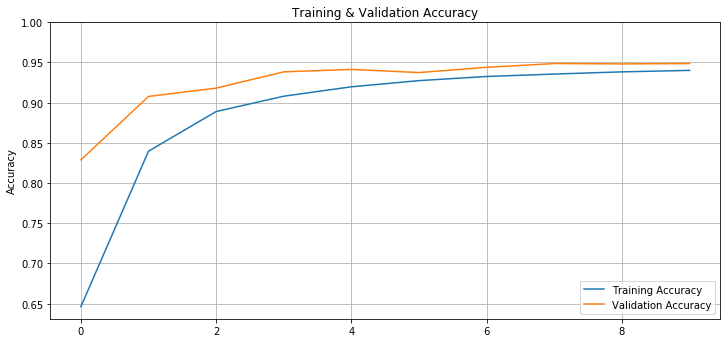

In [50]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.plot(acc_trn, label='Training Accuracy')
plt.plot(acc_val, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1.0])
plt.title('Training & Validation Accuracy')
plt.grid()
plt.show()

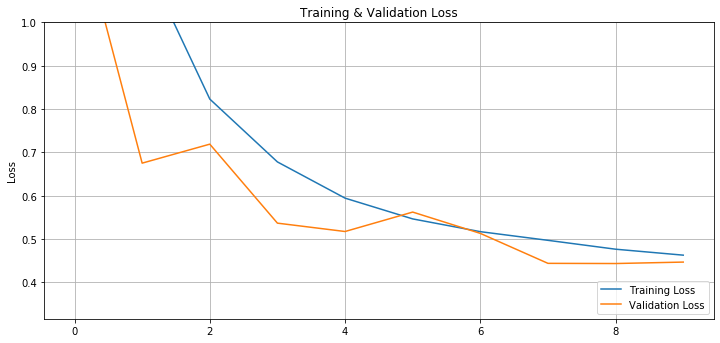

In [52]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.plot(loss_trn, label='Training Loss')
plt.plot(loss_val, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()), 1.0])
plt.title('Training & Validation Loss')
plt.grid()
plt.show()

In [54]:
model_base.trainable = True
for layer in model_base.layers[0:100]:
    layer.trainable = False

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      


W0610 11:26:53.847843 35504 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Total params: 396,673
Trainable params: 1,281
Non-trainable params: 395,392
_________________________________________________________________


In [57]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10.0), metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [60]:
len(model.trainable_variables)

58

In [61]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(batches_trn, epochs=total_epochs, initial_epoch=initial_epochs, 
                         validation_data = batches_val, verbose=2)

Epoch 11/20
582/582 - 137s - loss: 0.4179 - accuracy: 0.9494 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 12/20
582/582 - 84s - loss: 0.3342 - accuracy: 0.9712 - val_loss: 0.1843 - val_accuracy: 0.9741
Epoch 13/20
582/582 - 84s - loss: 0.2965 - accuracy: 0.9787 - val_loss: 0.2016 - val_accuracy: 0.9733
Epoch 14/20
582/582 - 85s - loss: 0.2759 - accuracy: 0.9810 - val_loss: 0.1835 - val_accuracy: 0.9750
Epoch 15/20
582/582 - 89s - loss: 0.2628 - accuracy: 0.9822 - val_loss: 0.1925 - val_accuracy: 0.9733
Epoch 16/20
582/582 - 86s - loss: 0.2532 - accuracy: 0.9831 - val_loss: 0.1875 - val_accuracy: 0.9750
Epoch 17/20
582/582 - 87s - loss: 0.2478 - accuracy: 0.9837 - val_loss: 0.1929 - val_accuracy: 0.9741
Epoch 18/20
582/582 - 84s - loss: 0.2418 - accuracy: 0.9839 - val_loss: 0.2086 - val_accuracy: 0.9733
Epoch 19/20
582/582 - 84s - loss: 0.2378 - accuracy: 0.9844 - val_loss: 0.2155 - val_accuracy: 0.9746
Epoch 20/20
582/582 - 82s - loss: 0.2351 - accuracy: 0.9845 - val_loss: 0

In [62]:
model.save('10-transfer-learning-cnn.h5')

In [70]:
acc_trn += history_fine.history['accuracy']
acc_val += history_fine.history['val_accuracy']

In [71]:
loss_trn += history_fine.history['loss']
loss_val += history_fine.history['val_loss']

In [72]:
vartbl['acc_trn'] = acc_trn
vartbl['acc_val'] = acc_val
vartbl['loss_trn'] = loss_trn
vartbl['loss_val'] = loss_val

In [81]:
utils.save_vartbl(vartbl, fname)